In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
from statsbombpy import sb
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pandas import json_normalize
import numpy as np
from pitch import Pitch #
import warnings

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
sb.competitions()

c:\Users\rohit\Desktop\VIZ\E\Footy\otot_task_e\lib\site-packages\statsbombpy\api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-07-09T14:06:05.802
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
5,16,25,Europe,Champions League,male,False,False,2013/2014,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
6,16,24,Europe,Champions League,male,False,False,2012/2013,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-07-10T13:41:45.751
7,16,23,Europe,Champions League,male,False,False,2011/2012,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
8,16,22,Europe,Champions League,male,False,False,2010/2011,2022-01-26T21:07:11.033473,2021-06-13T16:17:31.694,None,2022-01-26T21:07:11.033473
9,16,21,Europe,Champions League,male,False,False,2009/2010,2022-02-12T16:13:49.294747,2021-06-13T16:17:31.694,None,2022-02-12T16:13:49.294747


In [16]:
side = "away"

In [2]:
def load_file(match_id):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json")
    match_dict = json.loads(resp.text)
    df = json_normalize(match_dict, sep="_")
    df = df.query("location == location")
    df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
    ##Reversing the y-axis co-ordinates because Statsbomb use this reversed co-ordinate system
    df['y'] = 80 - df['y']
    df['location'] = df[['x', 'y']].apply(list, axis=1)
    return match_dict, df

In [3]:
match_dict, df = load_file(match_id=)

In [18]:
side_dict = {"home": match_dict[0]["team"]["name"],
             "away": match_dict[1]["team"]["name"] }


In [19]:
def get_starters(match_dict, side="home"):
    lineups = match_dict[0]["tactics"]["lineup"] if side == "home" else match_dict[1]["tactics"]["lineup"]
    return lineups

In [20]:
lineups = get_starters(match_dict, side=side)

In [21]:
lineups

[{'player': {'id': 6629, 'name': 'Fernando Pacheco Flores'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'jersey_number': 1},
 {'player': {'id': 6618, 'name': 'Martín Aguirregabiria Padilla'},
  'position': {'id': 2, 'name': 'Right Back'},
  'jersey_number': 21},
 {'player': {'id': 6615, 'name': 'Víctor Laguardia Cisneros'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'jersey_number': 5},
 {'player': {'id': 6855, 'name': 'Guillermo Alfonso Maripán Loaysa'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'jersey_number': 6},
 {'player': {'id': 6612, 'name': 'Rubén Duarte Sánchez'},
  'position': {'id': 6, 'name': 'Left Back'},
  'jersey_number': 3},
 {'player': {'id': 6839, 'name': 'Daniel Alejandro Torres Rojas'},
  'position': {'id': 10, 'name': 'Center Defensive Midfield'},
  'jersey_number': 16},
 {'player': {'id': 6617, 'name': 'Ibai Gómez Pérez'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'jersey_number': 11},
 {'player': {'id': 6626, 'name': '

In [22]:
class Player:
    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):

        player_pass_df = df.query("(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
        self.x, self.y = np.mean(player_pass_df['location'].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)


In [23]:
player_objs_dict = {}
starters = []
for player in lineups:
    starters.append(player["player"]["name"]) ##To remove all substitutes from our final grouped_df
    p = Player(player, df) ##Calling the Player class
    player_objs_dict.update({player["player"]["name"]: p}) ##For lookup during plotting the grouped_df


In [24]:
min_pass_count = 2

In [25]:
total_pass_df = df.query(f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &"\
                                 f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
total_pass_df = total_pass_df.groupby(["player_name", "pass_recipient_name"]).size().reset_index(name="count")
total_pass_df = total_pass_df.query(" (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) ")

In [26]:
print(total_pass_df)

                         player_name               pass_recipient_name  count
4      Daniel Alejandro Torres Rojas  Guillermo Alfonso Maripán Loaysa      2
6      Daniel Alejandro Torres Rojas       Jonathan Rodríguez Menéndez      2
10     Daniel Alejandro Torres Rojas              Rubén Duarte Sánchez      4
11     Daniel Alejandro Torres Rojas             Rubén Sobrino Pozuelo      2
13           Fernando Pacheco Flores  Guillermo Alfonso Maripán Loaysa      2
14           Fernando Pacheco Flores   Manuel Alejandro García Sánchez      2
16  Guillermo Alfonso Maripán Loaysa     Daniel Alejandro Torres Rojas      2
17  Guillermo Alfonso Maripán Loaysa           Fernando Pacheco Flores      3
18  Guillermo Alfonso Maripán Loaysa                  Ibai Gómez Pérez      2
21  Guillermo Alfonso Maripán Loaysa              Rubén Duarte Sánchez      3
26                  Ibai Gómez Pérez     Martín Aguirregabiria Padilla      5
27                  Ibai Gómez Pérez                    Mubarak 

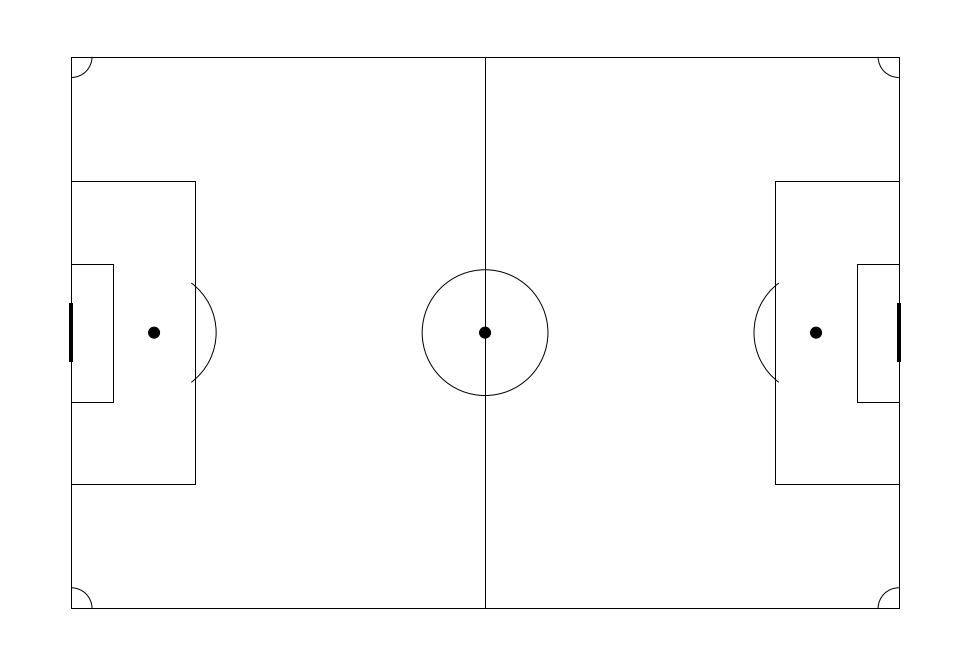

In [45]:
marker_color  = "magenta"
player_color ="red"
side_color ="yellow"
 ##minimum number of passes for a link to be plotted

fig, ax = plt.subplots()
ax = Pitch(ax)


In [46]:
arrow_shift = 1 ##Units by which the arrow moves from its original position
shrink_val = 1.5 ##Units by which the arrow is shortened from the end_points

##Visualising the passmap

for row in total_pass_df.itertuples():

    link = row[3] ## for the arrow-width and the alpha
    passer = player_objs_dict[row[1]]
    receiver = player_objs_dict[row[2]]

    alpha = link/15
    if alpha >1:
        alpha=1

    if abs( receiver.x - passer.x) > abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x, receiver.y + arrow_shift), xytext=(passer.x, passer.y + arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw = link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x, receiver.y - arrow_shift), xytext=(passer.x, passer.y - arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

    elif abs(receiver.x - passer.x) <= abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x + arrow_shift, receiver.y), xytext=(passer.x + arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x - arrow_shift, receiver.y), xytext=(passer.x - arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

In [47]:
for name, player in player_objs_dict.items():

    ax.scatter(player.x, player.y, s=player.n_passes_completed*1.3, color=marker_color, zorder = 4)
    ax.text(player.x, player.y+2 if player.y >40 else player.y -2, s=player.name.split(" ")[-1], rotation=270, va="top" if player.y<40 else "bottom", size=13, fontweight="book", zorder=7, color=player_color)

ax.text(124, 80, f"{side_dict[side]}", size=24, fontweight="demibold", rotation=270, color=side_color, va="top")
ax.text(122, 80, f"{side_dict['home']} vs {side_dict['away']}", size=16, fontweight="demibold", rotation = 270, va="top")

fig.tight_layout()

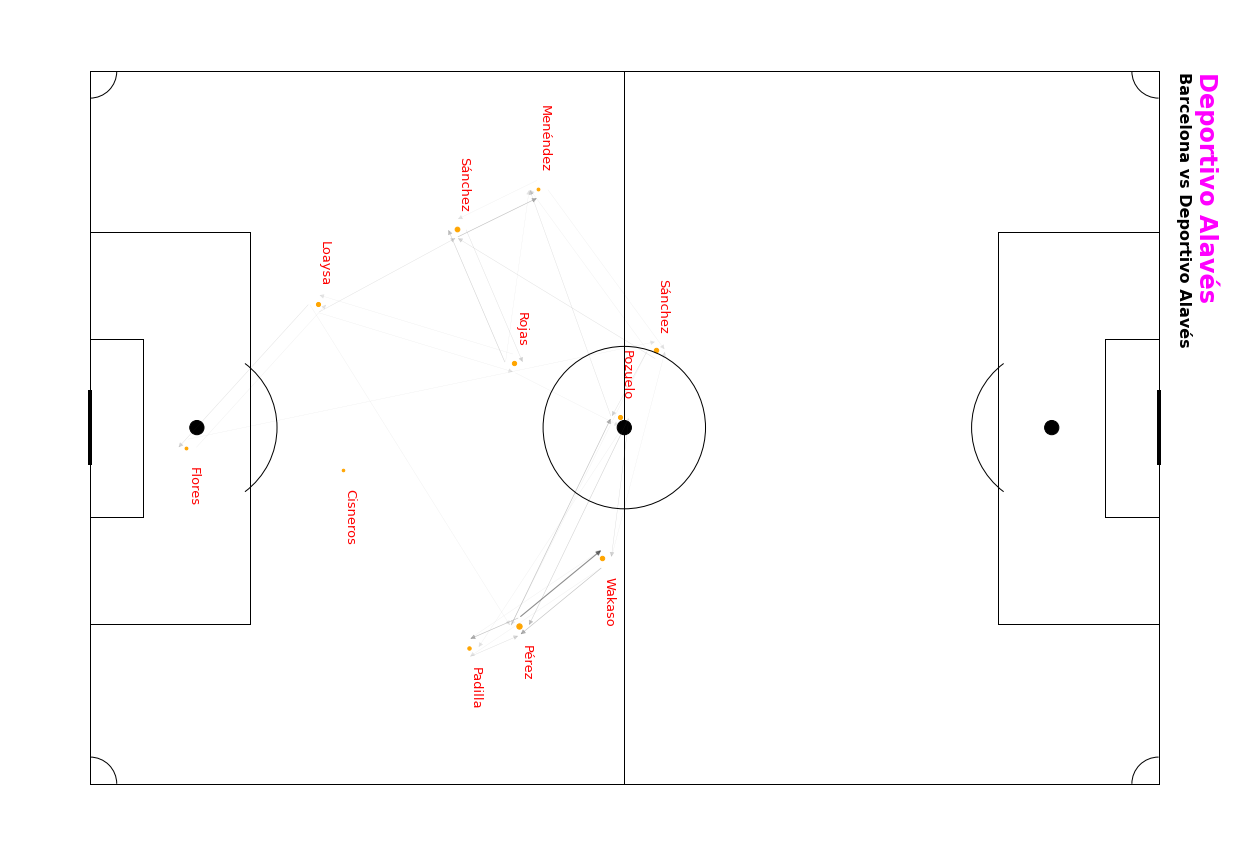

In [48]:
fig.savefig('./rj.jpg')
fig